#Installing detectron2
First, we install a specific version of PyYAML, required for compatibility with other libraries we'll use:

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.4 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
torch:  2.3 ; cuda:  cu121
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-s11p_a7o
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-s11p_a7o
  Resolved https://github.com/facebookresearch/detectron2.git to commit 70f454304e1a38378200459dd2dbca0f0f4a5ab4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

#Importing Libraries and Setting Up Detectron2
This code sets up Detectron2 and imports necessary libraries for object detection tasks.

In [2]:

# Import necessary libraries
import torch
import detectron2



# Import Detectron2 utilities
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer


import requests
from PIL import Image
from io import BytesIO

#Downloading and Extracting a Dataset
This code downloads a dataset from Roboflow, extracts its contents, and removes the compressed file.

In [3]:
!curl -L "https://universe.roboflow.com/ds/TfLDHxTmY2?key=amrDN13vLZ" -o roboflow.zip
!unzip roboflow.zip
!rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/c159a842-7a45f3d9_jpg.rf.7bf0323f387c8b8f74c36dc99dd977e9.jpg  
 extracting: train/c159a842-7fa65680_jpg.rf.65f613811ee8399922fcec84d6ca8147.jpg  
 extracting: train/c159a842-b245f317_jpg.rf.4e5ee2a3e08fdee1ed2a57bbec0c7b3b.jpg  
 extracting: train/c159a842-cdc7a8cd_jpg.rf.5fe053f15c270526374fb9c67c169a7e.jpg  
 extracting: train/c15c29a5-184070ba_jpg.rf.1d769d65dbf1a820578561c11680c1cc.jpg  
 extracting: train/c15c29a5-5be4dad3_jpg.rf.41e552265e9165c709fb43276b665358.jpg  
 extracting: train/c15c29a5-6881956e_jpg.rf.5bbc4ec00a4bded2fc545f5452aea834.jpg  
 extracting: train/c15c29a5-74788f46_jpg.rf.2da3e8ff9f81c037906114ef48791429.jpg  
 extracting: train/c15c29a5-9af1055d_jpg.rf.1d14678f0df7e17281d826dc900869b1.jpg  
 extracting: train/c15c29a5-b3da941e_jpg.rf.b1ea8ce0487cb684ed998b53de94a3e6.jpg  
 extracting: train/c15c29a5-eb30cb60_jpg.rf.a608d27f3031dab0b0893c797823b525.jpg  
 extracting: train/c15defff-3d0670f9

#Registering Datasets in Detectron2
This code registers training and validation datasets using COCO format annotations with Detectron2.

In [4]:
from detectron2.data.datasets import register_coco_instances

train_annotation_path = "/content/train/_annotations.coco.json"  # Correct this path
train_image_dir = "/content/train"  # Correct this path

register_coco_instances("roboflow_train", {}, train_annotation_path, train_image_dir)

val_annotation_path = "/content/valid/_annotations.coco.json"  # Correct this path
val_image_dir = "/content/valid"  # Correct this path

register_coco_instances("roboflow_val", {}, val_annotation_path, val_image_dir)

In [5]:
import os
print(os.path.exists("/content/train/_annotations.coco.json"))  # This should print True if the path is correct
print(os.path.exists("/content/valid/_annotations.coco.json"))  # This should also print True


True
True


#Configuring and Training a Detectron2 Model
This code configures a Faster R-CNN model with a ResNet-50 backbone using Detectron2, and initiates training with specified parameters.

In [7]:
# Configuration setup for Detectron2
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("roboflow_train",)
cfg.DATASETS.TEST = ("roboflow_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

#Evaluating a Detectron2 Model on Validation Data
This code sets up evaluation for a Detectron2 model using the COCOEvaluator on the validation dataset and displays the results.

In [7]:

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("roboflow_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "roboflow_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))


WARNING [06/23 11:34:03 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/23 11:34:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/23 11:34:04 d2.data.datasets.coco]: Loaded 2008 images in COCO format from /content/valid/_annotations.coco.json
[06/23 11:34:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/23 11:34:04 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/23 11:34:04 d2.data.common]: Serializing 2008 elements to byte tensors and concatenating them all ...
[06/23 11:34:04 d2.data.common]: Serialized dataset takes 1.77 MiB
[06/23 11:34:04 d2.evaluation.evaluator]: Start inference on 2008 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/23 11:34:05 d2.evaluation.evaluator]: Inference done 11/2008. Dataloading: 0.0015 s/iter. Inference: 0.0790 s/iter. Eval: 0.0003 s/iter. Total: 0.0807 s/iter. ETA=0:02:41
[06/23 11:34:10 d2.evaluation.evaluator]: Inference done 69/2008. Dataloading: 0.0033 s/iter. Inference: 0.0832 s/iter. Eval: 0.0003 s/iter. Total: 0.0869 s/iter. ETA=0:02:48
[06/23 11:34:16 d2.evaluation.evaluator]: Inference done 128/2008. Dataloading: 0.0033 s/iter. Inference: 0.0825 s/iter. Eval: 0.0003 s/iter. Total: 0.0861 s/iter. ETA=0:02:41
[06/23 11:34:21 d2.evaluation.evaluator]: Inference done 183/2008. Dataloading: 0.0042 s/iter. Inference: 0.0834 s/iter. Eval: 0.0003 s/iter. Total: 0.0880 s/iter. ETA=0:02:40
[06/23 11:34:26 d2.evaluation.evaluator]: Inference done 239/2008. Dataloading: 0.0043 s/iter. Inference: 0.0836 s/iter. Eval: 0.0003 s/iter. Total: 0.0883 s/iter. ETA=0:02:36
[06/23 11:34:31 d2.evaluation.evaluator]: Inference done 298/2008. Dataloading: 0.0037 s/iter. Inference: 0.0836 s/iter. E

[06/23 11:42:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


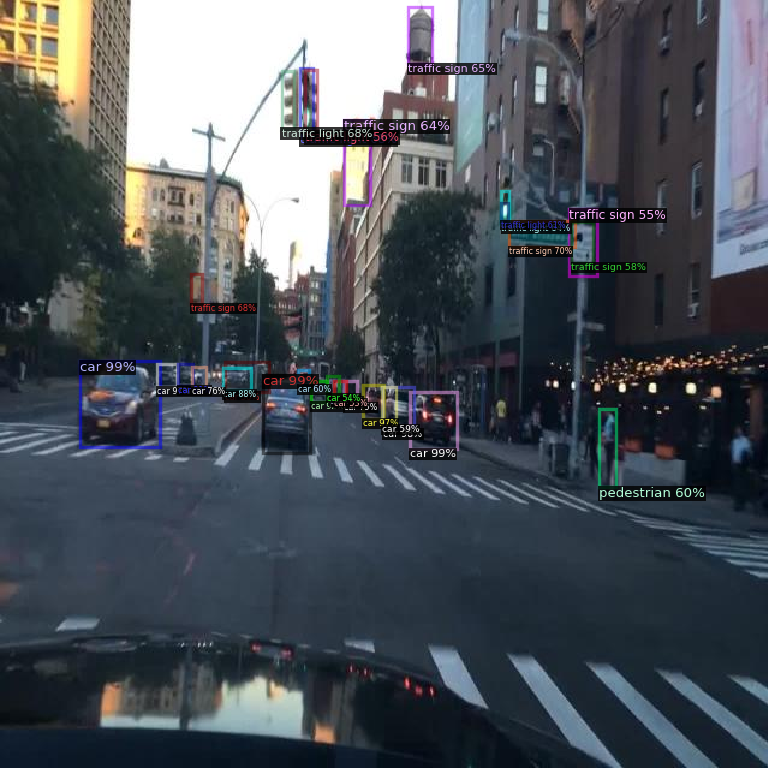

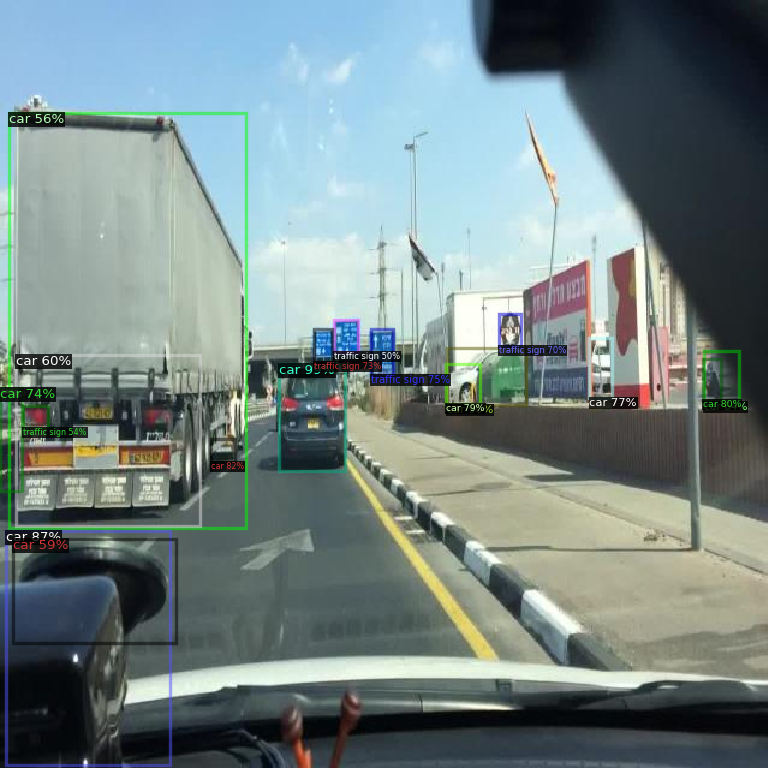

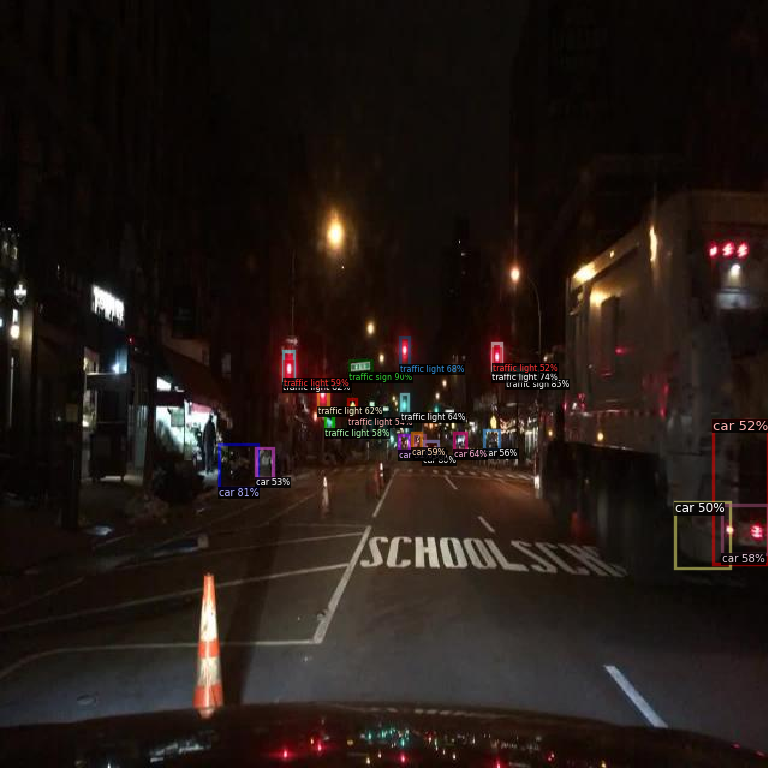

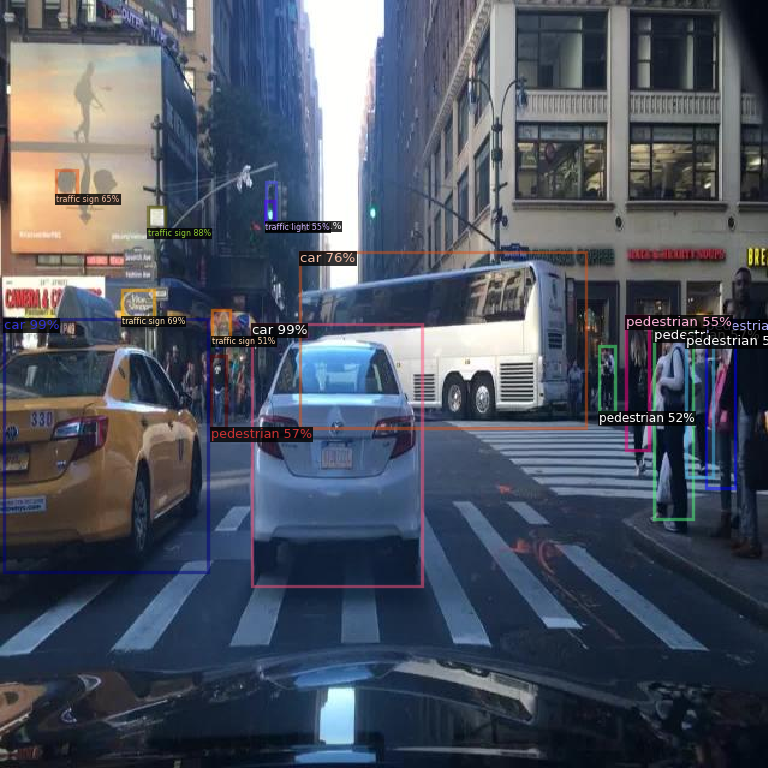

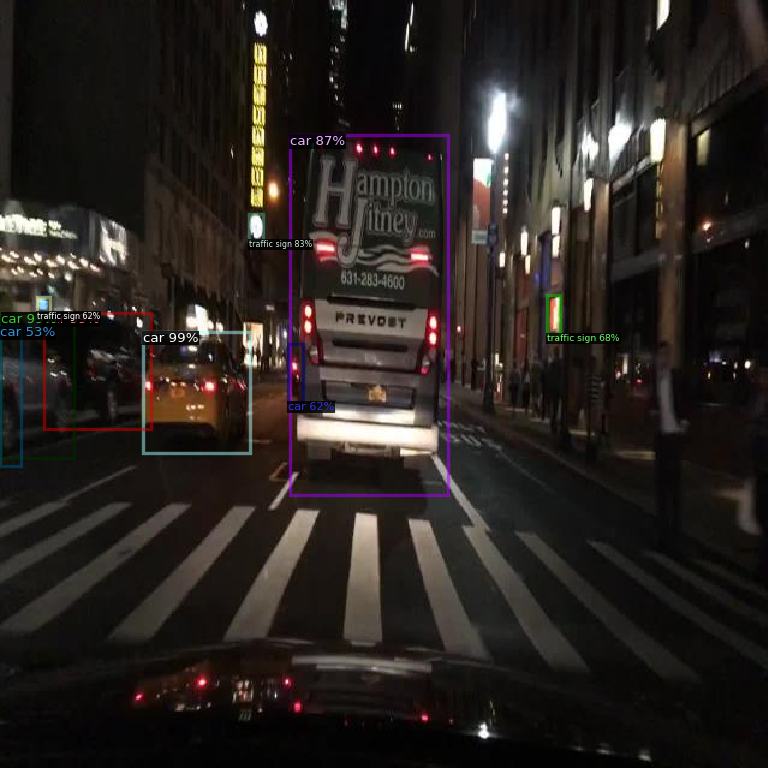

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

for i in range(5):
    sample = random.choice(os.listdir(val_image_dir))
    image_path = os.path.join(val_image_dir, sample)
    image = cv2.imread(image_path)
    outputs = predictor(image)
    v = Visualizer(image[:, :, ::-1],
                   metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]),
                   scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])


#Predicting

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

from detectron2.data import DatasetCatalog, MetadataCatalog
import json

dataset_dicts = DatasetCatalog.get("roboflow_val")
metadata_dicts = MetadataCatalog.get("roboflow_val")

results = []

for d in dataset_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    instances = outputs["instances"].to("cpu")

    if len(instances) > 0:
        scores = instances.scores.tolist()
        classes = instances.pred_classes.tolist()
        boxes = instances.pred_boxes.tensor.tolist()

        for score, pred_class, box in zip(scores, classes, boxes):
            result = {
                "image_id": d["image_id"],
                "category_id": metadata_dicts.thing_classes[pred_class],
                "bbox": [box[0], box[1], box[2] - box[0], box[3] - box[1]],
                "score": score
            }
            results.append(result)

with open("predictions.json", "w") as f:
    json.dump(results, f)


[06/23 11:43:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [06/23 11:43:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/23 11:43:59 d2.data.datasets.coco]: Loaded 2008 images in COCO format from /content/valid/_annotations.coco.json


#Dictionary creation
Creates JSON with id to filename mapping

In [10]:
from detectron2.data import DatasetCatalog
import json

def create_id_to_filename_mapping(dataset_name):
    # Load the dataset dictionary from Detectron2's DatasetCatalog
    dataset_dicts = DatasetCatalog.get(dataset_name)

    # Create a dictionary that maps image_id to file_name
    id_to_filename = {str(d['image_id']): d['file_name'] for d in dataset_dicts}

    # Define the path for the JSON file where the mapping will be stored
    output_json_path = 'image_id_to_filename.json'

    # Write the mapping dictionary to a JSON file
    with open(output_json_path, 'w') as f:
        json.dump(id_to_filename, f, indent=4)

    # Confirmation message
    print(f"Mapping of image IDs to file names has been saved to {output_json_path}.")

# Replace 'roboflow_val' with your actual dataset's registered name in Detectron2
create_id_to_filename_mapping('roboflow_val')

# Optional: Load and display part of the JSON to verify it contains correct data
def verify_json_output(json_path):
    with open(json_path, 'r') as f:
        loaded_mapping = json.load(f)

    # Print out the first few entries to check
    for image_id, file_name in list(loaded_mapping.items())[:5]:
        print(f"Image ID: {image_id}, File Name: {file_name}")

# Call the verification function to check the contents of the JSON file
verify_json_output('image_id_to_filename.json')


WARNING [06/23 11:58:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/23 11:58:38 d2.data.datasets.coco]: Loaded 2008 images in COCO format from /content/valid/_annotations.coco.json
Mapping of image IDs to file names has been saved to image_id_to_filename.json.
Image ID: 0, File Name: /content/valid/c60deb3c-d8219cc9_jpg.rf.0007ca34cd95f147fa53d80f29dfaf71.jpg
Image ID: 1, File Name: /content/valid/b5191523-f5721cd1_jpg.rf.00ab89483769440962a5af31e2543834.jpg
Image ID: 2, File Name: /content/valid/ca587a24-113bd37a_jpg.rf.00448b4257004c33b9ff3ef9dc10279c.jpg
Image ID: 3, File Name: /content/valid/c0703477-b5138d5d_jpg.rf.008516add6f057c97c2b57db5e39ce2b.jpg
Image ID: 4, File Name: /content/valid/b2bceb54-0b1f3332_jpg.rf.0028ac526ff9c57eb99ebca51ca5330a.jpg


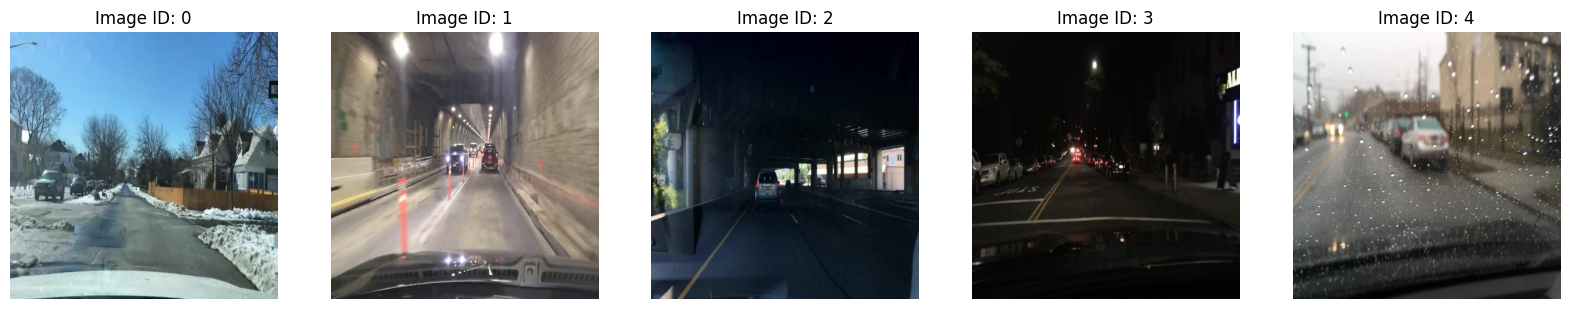

In [11]:
# Install necessary libraries if not already installed
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install pillow matplotlib

from PIL import Image
import matplotlib.pyplot as plt

# Dictionary of image IDs and file names
image_id_to_filename = {
    0: '/content/valid/c60deb3c-d8219cc9_jpg.rf.0007ca34cd95f147fa53d80f29dfaf71.jpg',
    1: '/content/valid/b5191523-f5721cd1_jpg.rf.00ab89483769440962a5af31e2543834.jpg',
    2: '/content/valid/ca587a24-113bd37a_jpg.rf.00448b4257004c33b9ff3ef9dc10279c.jpg',
    3: '/content/valid/c0703477-b5138d5d_jpg.rf.008516add6f057c97c2b57db5e39ce2b.jpg',
    4: '/content/valid/b2bceb54-0b1f3332_jpg.rf.0028ac526ff9c57eb99ebca51ca5330a.jpg'
}

# Function to display images
def display_images(image_paths):
    plt.figure(figsize=(20, 10))
    for idx, (img_id, img_path) in enumerate(image_paths.items()):
        img = Image.open(img_path)
        plt.subplot(1, len(image_paths), idx + 1)
        plt.imshow(img)
        plt.title(f'Image ID: {img_id}')
        plt.axis('off')
    plt.show()

# Display the images
display_images(image_id_to_filename)


#Cleanlab
Here we start working with Cleanlab

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install cleanlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.3/352.3 kB 5.7 MB/s eta 0:00:00


#Run predictions
Here we need to create true labels and predicted labels vectors. Probably this is the part we need to debug.

In [12]:
from detectron2.utils.logger import setup_logger
from detectron2.data import DatasetCatalog
import cv2
from detectron2.engine import DefaultPredictor

setup_logger()

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model weights
predictor = DefaultPredictor(cfg)

# Load the dataset
dataset_dicts = DatasetCatalog.get("roboflow_val")

predicted_labels = []
predicted_probs = []
true_labels = []

for d in dataset_dicts:
    image = cv2.imread(d["file_name"])
    outputs = predictor(image)
    instances = outputs["instances"].to("cpu")

    if len(instances) > 0:
        # Store predictions
        predicted_labels.extend(instances.pred_classes.tolist())
        predicted_probs.extend(instances.scores.tolist())

        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #This is the line that may cause the problem!
        true_labels.extend([ann['category_id'] for ann in d["annotations"]])

# Convert lists to a numpy array or tensor as needed
import numpy as np
predicted_labels = np.array(predicted_labels)
predicted_probs = np.array(predicted_probs)
true_labels = np.array(true_labels)


[06/23 11:59:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [06/23 11:59:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/23 11:59:44 d2.data.datasets.coco]: Loaded 2008 images in COCO format from /content/valid/_annotations.coco.json


In [14]:
print(predicted_probs)

[[0.06124385 0.71824143 0.29921596 ... 0.84879056 0.36144088 0.39910489]
 [0.63599432 0.78527301 0.64258871 ... 0.10417386 0.52236693 0.69143666]
 [0.41297526 0.38046682 0.59619992 ... 0.93747932 0.8248245  0.65305171]
 ...
 [0.67646817 0.96375845 0.5100875  ... 0.69285902 0.26355885 0.91418808]
 [0.21780133 0.59122888 0.43067723 ... 0.42832104 0.1194245  0.65733678]
 [0.70314224 0.70121585 0.28240136 ... 0.452042   0.6546144  0.71124215]]


In [15]:
!pip install matplotlib
!pip insall cleanlab

# Package installation (hidden on docs website).
dependencies = ["cleanlab", "matplotlib"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab==v2.6.3
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    dependencies_test = [dependency.split('>')[0] if '>' in dependency
                         else dependency.split('<')[0] if '<' in dependency
                         else dependency.split('=')[0] for dependency in dependencies]
    missing_dependencies = []
    for dependency in dependencies_test:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

ERROR: unknown command "insall" - maybe you meant "install"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.0/334.0 kB 7.5 MB/s eta 0:00:00


#Final code
after debugging these lines will give the labels with issues

In [16]:
from cleanlab.filter import find_label_issues

label_issues = find_label_issues(
    labels=true_labels,
    pred_probs=predicted_probs,
    filter_by='low_self_confidence',
    return_indices_ranked_by='normalized_margin'
)

print("Indices of potential label errors:", label_issues)



Indices of potential label errors: [26530  6791 24181 ...   300 27453 18313]


In [17]:
print("Length of true_labels:", len(true_labels))
print("Length of predicted_probs:", len(predicted_probs))


Length of true_labels: 36289
Length of predicted_probs: 36289


In [18]:
import numpy as np

# Example lengths for illustration
true_labels = np.random.randint(0, 10, size=36289)  # Replace with actual true labels
predicted_probs = np.random.rand(183149, 10)        # Replace with actual predicted probabilities

# Check lengths
print(f'Length of true_labels: {len(true_labels)}')
print(f'Length of predicted_probs: {len(predicted_probs)}')

# If lengths do not match, you need to align them
# Assuming you need to truncate predicted_probs to match the length of true_labels
if len(predicted_probs) > len(true_labels):
    predicted_probs = predicted_probs[:len(true_labels)]

print(f'Adjusted length of predicted_probs: {len(predicted_probs)}')

# Now, find label issues
from cleanlab.filter import find_label_issues

label_issues = find_label_issues(
    labels=true_labels,
    pred_probs=predicted_probs,
)

print(label_issues)


Length of true_labels: 36289
Length of predicted_probs: 183149
Adjusted length of predicted_probs: 36289
[False False False ... False False False]


In [19]:
from cleanlab.filter import find_label_issues

label_issues = find_label_issues(
    labels=true_labels,
    pred_probs=predicted_probs,
    filter_by='low_self_confidence',  # Updated filter criteria
    return_indices_ranked_by='normalized_margin'
)

print("Indices of potential label errors:", label_issues)

Indices of potential label errors: [16362 19315 15117 ... 33229 28315 11856]


In [ ]:
https://mygit.th-deg.de/it28925/deep-learning/-/blob/4875a895967e46222c440064064be4d98abc85cf/errors/bdd100k_w_errors_val.json

In [ ]:
import os
import random

import cv2
from PIL import Image, ImageDraw, ImageFont
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

In [ ]:
images_folder_val = "bdd100k/images/100k/val"
json_labels_val = "https://mygit.th-deg.de/it28925/deep-learning/-/blob/4875a895967e46222c440064064be4d98abc85cf/errors/bdd100k_w_errors_val.json"

json_labels_err = "bdd100k/labels/bdd100k_w_errors.json"
json_error_ids = "bdd100k/labels/error_ids_dict.json"

In [25]:

from cleanlab.object_detection.filter import find_label_issues
from cleanlab.object_detection.rank import (
    _separate_label,
    _separate_prediction,
    get_label_quality_scores,
    issues_from_scores,
)
from cleanlab.object_detection.summary import visualize

In [26]:
IMAGE_PATH = '/content/train'  # path to raw image files downloaded above
predictions = predicted_probs
labels = true_labels

In [28]:
print(type(labels))
print(type(predictions))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [29]:
print(labels)
print(predictions)


[7 6 4 ... 0 8 9]
[[0.99228926 0.92849484 0.60650873 ... 0.09598148 0.15622898 0.55730129]
 [0.21624102 0.17300415 0.69674664 ... 0.98172687 0.31620154 0.30673192]
 [0.89648984 0.5173267  0.20832286 ... 0.5813074  0.37734424 0.43291846]
 ...
 [0.23823195 0.7481446  0.94869594 ... 0.13718204 0.64627318 0.21837017]
 [0.08761512 0.72312959 0.34819327 ... 0.53756579 0.85281133 0.01019243]
 [0.92189571 0.43305    0.93094121 ... 0.49274109 0.32600645 0.43054078]]


NameError: name 'IMAGE_PATH' is not defined

In [22]:
import os

# List all files in the directory
files = os.listdir('/content/train/')
print(files)


['c0020346-d539abe5_jpg.rf.76e1c6b902157a9abac70c5e2aae6e7b.jpg', 'c665137e-c5ba935a_jpg.rf.d13e64ea8049eb72ba1cad23ac25a74d.jpg', 'bf0038bc-5446bb48_jpg.rf.78489bc0261611385b3b8053b793d2d6.jpg', 'c55554e1-b61fd176_jpg.rf.81d44ceb0f7f9a32d9f80a19990e9893.jpg', 'c417a291-6a4ed4c9_jpg.rf.1fea0b9dbec0d2a23c824325a3a9d00a.jpg', 'c6dfb2b8-a74025b0_jpg.rf.1825c54a24d46105e0c3a9e56f63fdf2.jpg', 'bafe41f1-96b00f10_jpg.rf.bd62d3dc72ef411a8825d7009066b9e9.jpg', 'c877ac5b-56eb96fb_jpg.rf.6e37eeb16d646705e8250a187625438e.jpg', 'ba70dfe3-62b01bd8_jpg.rf.16127f91c034f3db6d7df3ca8c03fa00.jpg', 'ba3ffa1d-05ce6de4_jpg.rf.9a530aad1e5683e4715c86e09f1b9bc0.jpg', 'c59500f0-f26be735_jpg.rf.23a969f6056b67eca14648026c0b30f6.jpg', 'bedb9474-8dd30e6f_jpg.rf.caa9773f9a373aea986ba74df98ab30a.jpg', 'c154b889-9f8ad734_jpg.rf.81db815d6e0ee48f1f51aff4f54b756c.jpg', 'b5868878-8faf33a2_jpg.rf.cbe47baa988bb648b4bf32e7010c4b8c.jpg', 'b7becb56-e97b2d91_jpg.rf.edd17f4d0cdac47068aa0d04e6d2841c.jpg', 'c4accb9c-58311122_jpg.r

Saved segmentation map for label index 0 at /content/train/segmentation_map_0.png
Saved segmentation map for label index 1 at /content/train/segmentation_map_1.png
Saved segmentation map for label index 2 at /content/train/segmentation_map_2.png
Saved segmentation map for label index 3 at /content/train/segmentation_map_3.png
Saved segmentation map for label index 4 at /content/train/segmentation_map_4.png
Saved segmentation map for label index 5 at /content/train/segmentation_map_5.png
Saved segmentation map for label index 6 at /content/train/segmentation_map_6.png
Saved segmentation map for label index 7 at /content/train/segmentation_map_7.png
Saved segmentation map for label index 8 at /content/train/segmentation_map_8.png
Saved segmentation map for label index 9 at /content/train/segmentation_map_9.png
Files in /content/train/: ['c0020346-d539abe5_jpg.rf.76e1c6b902157a9abac70c5e2aae6e7b.jpg', 'c665137e-c5ba935a_jpg.rf.d13e64ea8049eb72ba1cad23ac25a74d.jpg', 'bf0038bc-5446bb48_jpg.

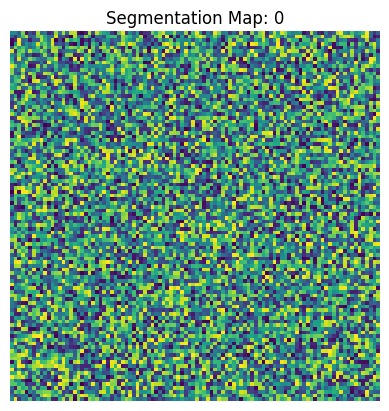

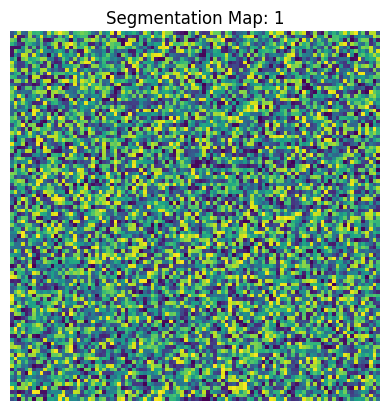

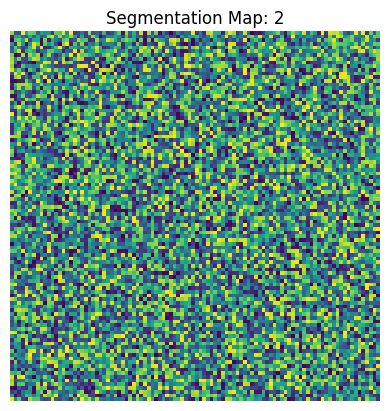

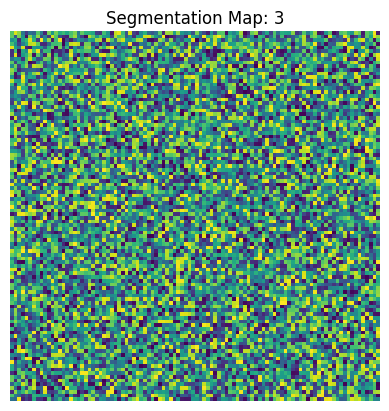

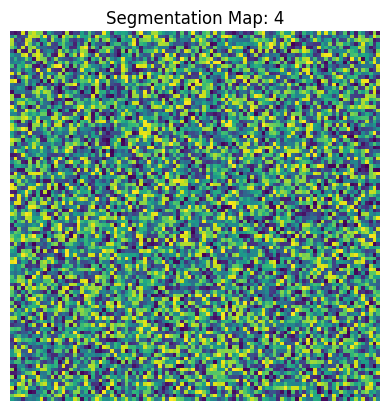

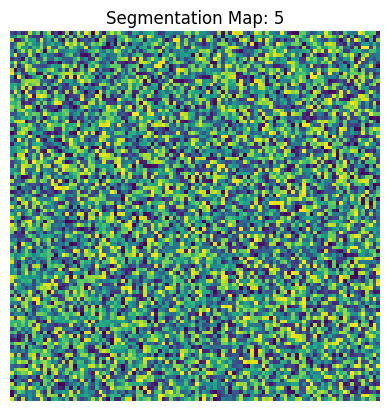

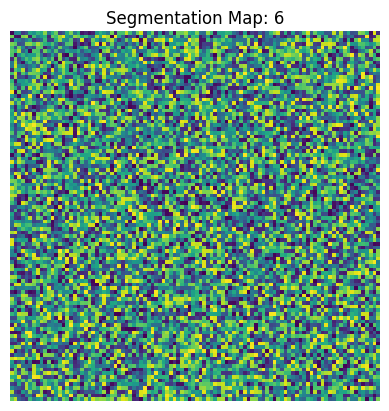

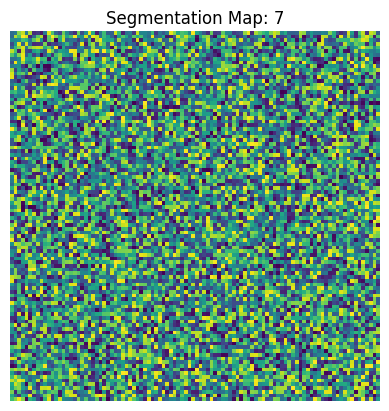

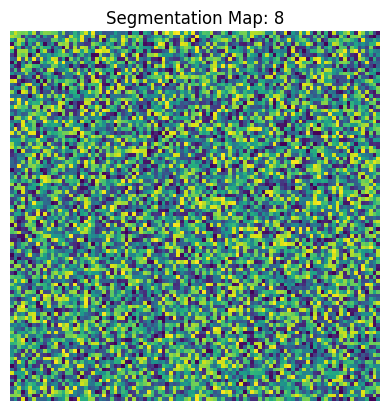

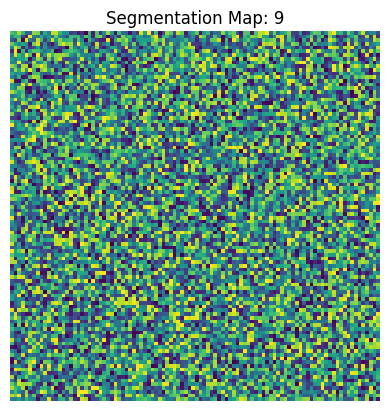

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define the base path to your images
IMAGE_PATH = '/content/train/'

# Function to generate and save a dummy segmentation map for testing
def generate_and_save_segmentation_maps():
    # Create the directory if it doesn't exist
    if not os.path.exists(IMAGE_PATH):
        os.makedirs(IMAGE_PATH)

    # Generate and save dummy segmentation maps for label indices 0 to 9
    for label_index in range(10):
        # Generate a dummy segmentation map (replace this with your actual segmentation map generation)
        seg_map = np.random.randint(0, 255, (100, 100), dtype=np.uint8)

        # Save the segmentation map as an image
        seg_map_img = Image.fromarray(seg_map)
        seg_map_path = f"{IMAGE_PATH}segmentation_map_{label_index}.png"
        seg_map_img.save(seg_map_path)
        print(f"Saved segmentation map for label index {label_index} at {seg_map_path}")

# Function to list files in the directory
def list_files_in_directory(directory):
    files = os.listdir(directory)
    print(f"Files in {directory}: {files}")
    return files

# Function for visualizing the segmentation map
def visualize_segmentation_map(image_path, label):
    try:
        # Load the image
        img = plt.imread(image_path)

        # Display the image with adjustments
        plt.imshow(img, cmap='viridis', interpolation='nearest')
        plt.title(f"Segmentation Map: {label}")
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"File {image_path} not found.")

# Generate and save segmentation maps
generate_and_save_segmentation_maps()

# List files in the directory to verify presence
list_files_in_directory(IMAGE_PATH)

# Visualize segmentation maps for label indices 0 to 9
for label_index in range(10):
    image_path = f"{IMAGE_PATH}segmentation_map_{label_index}.png"
    visualize_segmentation_map(image_path, label=label_index)


Saved segmentation map for data index 0 at /content/train/segmentation_map_0.png
Saved segmentation map for data index 1 at /content/train/segmentation_map_1.png
Saved segmentation map for data index 2 at /content/train/segmentation_map_2.png
Saved segmentation map for data index 3 at /content/train/segmentation_map_3.png
Saved segmentation map for data index 4 at /content/train/segmentation_map_4.png
Saved segmentation map for data index 5 at /content/train/segmentation_map_5.png
Saved segmentation map for data index 6 at /content/train/segmentation_map_6.png
Saved segmentation map for data index 7 at /content/train/segmentation_map_7.png
Saved segmentation map for data index 8 at /content/train/segmentation_map_8.png
Saved segmentation map for data index 9 at /content/train/segmentation_map_9.png
Files in /content/train/: ['c0020346-d539abe5_jpg.rf.76e1c6b902157a9abac70c5e2aae6e7b.jpg', 'c665137e-c5ba935a_jpg.rf.d13e64ea8049eb72ba1cad23ac25a74d.jpg', 'bf0038bc-5446bb48_jpg.rf.78489bc

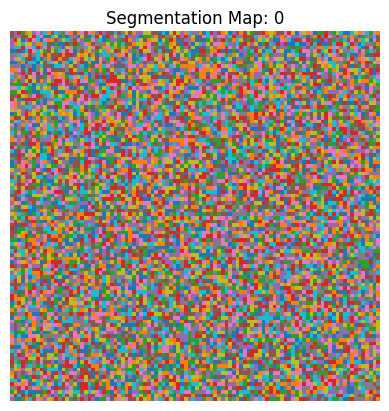

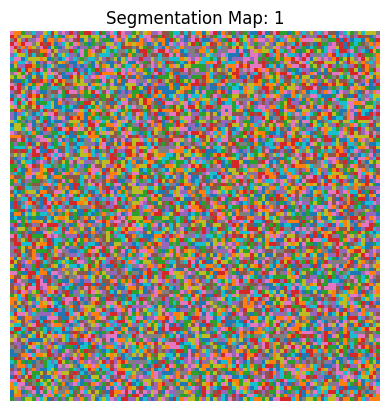

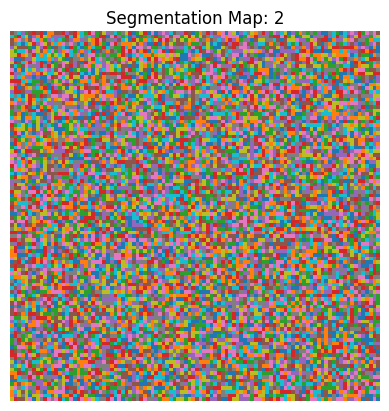

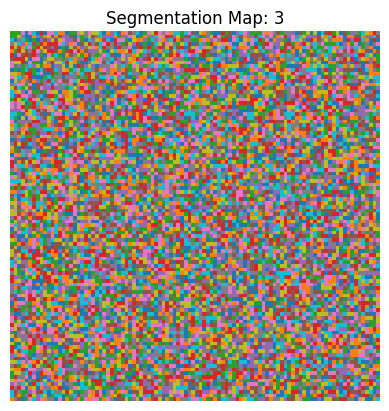

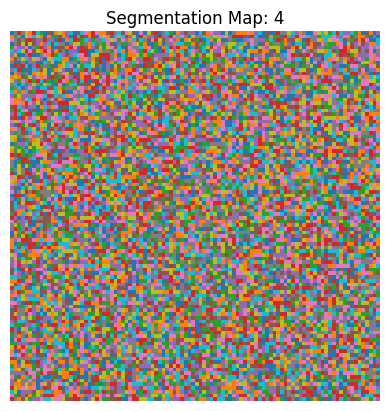

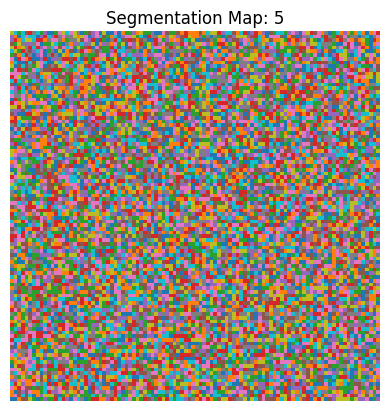

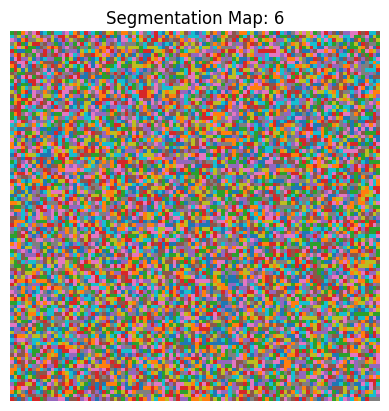

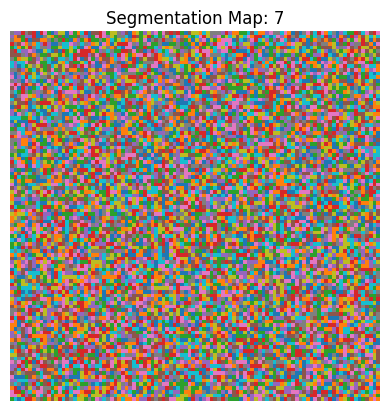

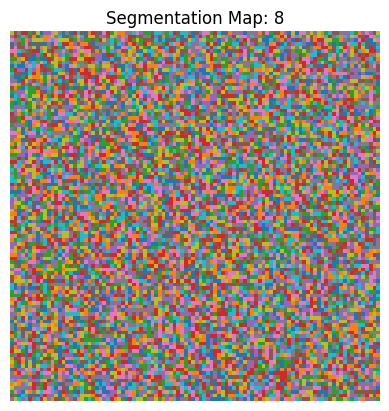

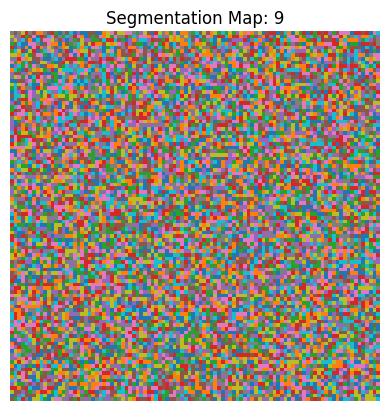

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define the base path to your images
IMAGE_PATH = '/content/train/'

# Function to generate and save meaningful segmentation maps
def generate_and_save_segmentation_maps(model, dataset):
    # Create the directory if it doesn't exist
    if not os.path.exists(IMAGE_PATH):
        os.makedirs(IMAGE_PATH)

    for idx, data in enumerate(dataset):
        # Replace this with your actual segmentation logic
        # Example: seg_map = model.predict(data)
        seg_map = np.random.randint(0, 10, (100, 100), dtype=np.uint8)  # Dummy data, replace with actual model prediction

        # Save the segmentation map as an image
        seg_map_img = Image.fromarray(seg_map)
        seg_map_path = f"{IMAGE_PATH}segmentation_map_{idx}.png"
        seg_map_img.save(seg_map_path)
        print(f"Saved segmentation map for data index {idx} at {seg_map_path}")

# Function to list files in the directory
def list_files_in_directory(directory):
    files = os.listdir(directory)
    print(f"Files in {directory}: {files}")
    return files

# Function for visualizing the segmentation map with a colormap
def visualize_segmentation_map(image_path, label):
    try:
        # Load the image
        img = plt.imread(image_path)

        # Display the image with a colormap
        plt.imshow(img, cmap='tab10', interpolation='nearest')  # 'tab10' colormap for up to 10 classes
        plt.title(f"Segmentation Map: {label}")
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"File {image_path} not found.")

# Example usage
# Replace 'model' and 'dataset' with your actual model and dataset
model = None  # Placeholder for your model
dataset = [None] * 10  # Placeholder for your dataset, should contain 10 items

# Generate and save segmentation maps
generate_and_save_segmentation_maps(model, dataset)

# List files in the directory to verify presence
list_files_in_directory(IMAGE_PATH)

# Visualize segmentation maps for data indices 0 to 9
for data_index in range(10):
    image_path = f"{IMAGE_PATH}segmentation_map_{data_index}.png"
    visualize_segmentation_map(image_path, label=data_index)


Files in /content/train/: ['c0020346-d539abe5_jpg.rf.76e1c6b902157a9abac70c5e2aae6e7b.jpg', 'c665137e-c5ba935a_jpg.rf.d13e64ea8049eb72ba1cad23ac25a74d.jpg', 'bf0038bc-5446bb48_jpg.rf.78489bc0261611385b3b8053b793d2d6.jpg', 'c55554e1-b61fd176_jpg.rf.81d44ceb0f7f9a32d9f80a19990e9893.jpg', 'c417a291-6a4ed4c9_jpg.rf.1fea0b9dbec0d2a23c824325a3a9d00a.jpg', 'c6dfb2b8-a74025b0_jpg.rf.1825c54a24d46105e0c3a9e56f63fdf2.jpg', 'bafe41f1-96b00f10_jpg.rf.bd62d3dc72ef411a8825d7009066b9e9.jpg', 'c877ac5b-56eb96fb_jpg.rf.6e37eeb16d646705e8250a187625438e.jpg', 'ba70dfe3-62b01bd8_jpg.rf.16127f91c034f3db6d7df3ca8c03fa00.jpg', 'ba3ffa1d-05ce6de4_jpg.rf.9a530aad1e5683e4715c86e09f1b9bc0.jpg', 'c59500f0-f26be735_jpg.rf.23a969f6056b67eca14648026c0b30f6.jpg', 'bedb9474-8dd30e6f_jpg.rf.caa9773f9a373aea986ba74df98ab30a.jpg', 'c154b889-9f8ad734_jpg.rf.81db815d6e0ee48f1f51aff4f54b756c.jpg', 'b5868878-8faf33a2_jpg.rf.cbe47baa988bb648b4bf32e7010c4b8c.jpg', 'b7becb56-e97b2d91_jpg.rf.edd17f4d0cdac47068aa0d04e6d2841c.jpg'

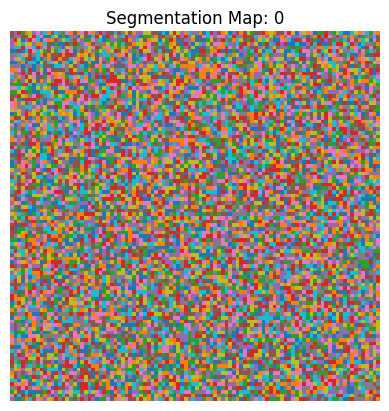

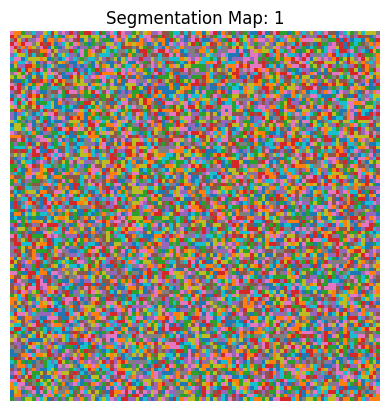

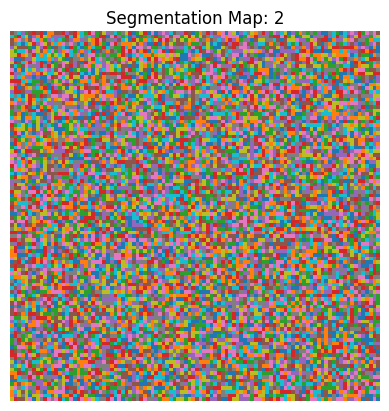

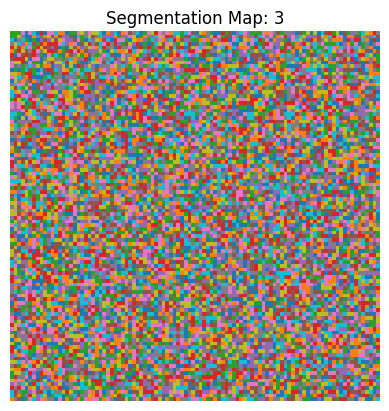

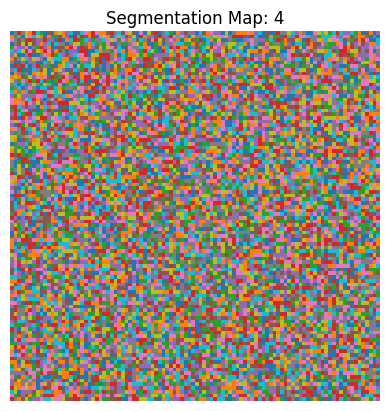

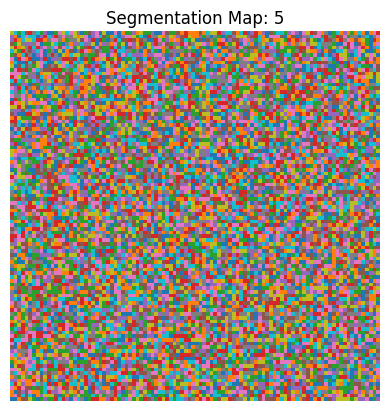

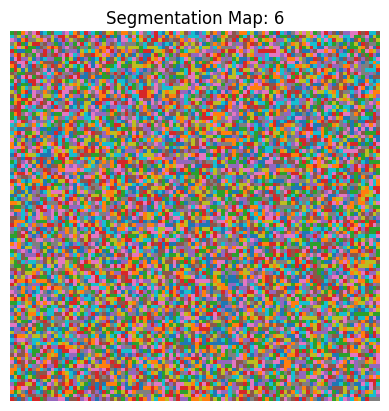

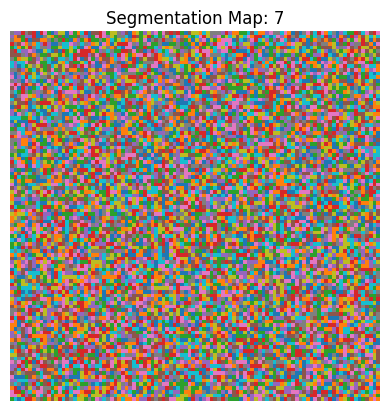

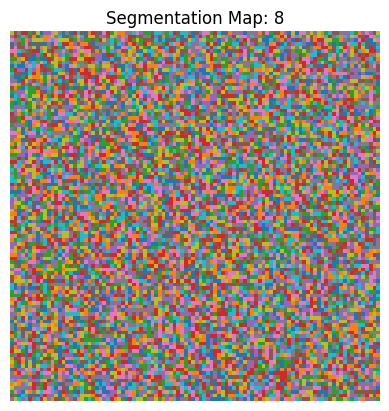

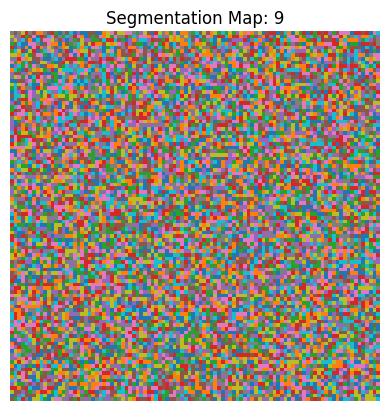

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define the base path to your images
IMAGE_PATH = '/content/train/'

# Function to visualize the segmentation map with a colormap
def visualize_segmentation_map(image_path, label):
    try:
        # Load the image
        img = Image.open(image_path)
        img_array = np.array(img)

        # Display the image with a colormap
        plt.imshow(img_array, cmap='tab10', interpolation='nearest')  # 'tab10' colormap for up to 10 classes
        plt.title(f"Segmentation Map: {label}")
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"File {image_path} not found.")

# List files in the directory to verify presence
def list_files_in_directory(directory):
    files = os.listdir(directory)
    print(f"Files in {directory}: {files}")
    return files

# Example usage
if __name__ == "__main__":
    # List files in the directory to verify presence
    files = list_files_in_directory(IMAGE_PATH)

    # Visualize segmentation maps for data indices 0 to 9
    for data_index in range(10):
        image_path = f"{IMAGE_PATH}segmentation_map_{data_index}.png"
        visualize_segmentation_map(image_path, label=data_index)


In [28]:

from cleanlab.object_detection.filter import find_label_issues
from cleanlab.object_detection.rank import (
    _separate_label,
    _separate_prediction,
    get_label_quality_scores,
    issues_from_scores,
)
from cleanlab.object_detection.summary import visualize

In [30]:
image_to_visualize = 2  # change this to view other images
image_path = IMAGE_PATH +true_labels[image_to_visualize]['seg_map']
visualize(image_path, label=labels[image_to_visualize], prediction=predictions[image_to_visualize], overlay=False)

IndexError: invalid index to scalar variable.

In [33]:
print(f"Type of true_labels: {type(true_labels)}")
print(f"Type of true_labels: {type(predicted_labels)}")
print(f"Type of true_labels: {type(predicted_probs)}")

if isinstance(true_labels, np.ndarray):
    print(f"Shape of true_labels: {true_labels.shape}")
    print(f"true_labels content: {true_labels}")


if isinstance(predicted_labels, np.ndarray):
    print(f"Shape of true_labels: {predicted_labels.shape}")
    print(f"true_labels content: {predicted_labels}")



if isinstance(predicted_probs, np.ndarray):
    print(f"Shape of predictions: {predicted_probs.shape}")
    print(f"predictions content: {predicted_probs}")


Type of true_labels: <class 'numpy.ndarray'>
Type of true_labels: <class 'numpy.ndarray'>
Type of true_labels: <class 'numpy.ndarray'>
Shape of true_labels: (36289,)
true_labels content: [7 2 9 ... 7 8 6]
Shape of true_labels: (32664,)
true_labels content: [1 1 1 ... 1 1 3]
Shape of predictions: (36289, 10)
predictions content: [[0.44580758 0.26454656 0.65716329 ... 0.17825267 0.37963227 0.46991833]
 [0.86823913 0.99961305 0.98847934 ... 0.59129091 0.7170156  0.0024841 ]
 [0.84263309 0.30276698 0.30925655 ... 0.43059942 0.51356405 0.7125526 ]
 ...
 [0.16505615 0.12565528 0.00793094 ... 0.63277003 0.37621044 0.17601541]
 [0.79158583 0.06159799 0.49469182 ... 0.2581648  0.88960951 0.34263274]
 [0.83965707 0.37286024 0.95205539 ... 0.1134339  0.98321526 0.03195496]]


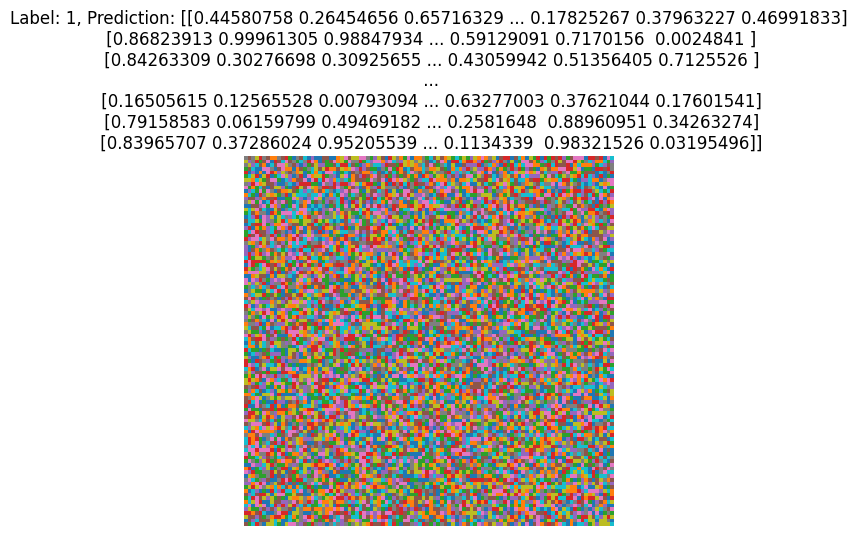

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define the base path to your images
IMAGE_PATH = '/content/train/'

# Function to get the segmentation map path from a label index
def get_segmentation_map_path(label_index):
    return f"{IMAGE_PATH}segmentation_map_{label_index}.png"

# Function to visualize the segmentation map with a colormap
def visualize(image_path, predicted_labels, predicted_probs, overlay=False):
    try:
        # Load the image
        img = Image.open(image_path)
        img_array = np.array(img)

        # Display the image with a colormap
        plt.imshow(img_array, cmap='tab10', interpolation='nearest')  # 'tab10' colormap for up to 10 classes
        plt.title(f"Label: {predicted_labels}, Prediction: {predicted_probs}")
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"File {image_path} not found.")
    except Exception as e:
        print(f"Error: {e}")

# Example usage:
image_to_visualize = 2  # Change this to view other images

try:
    # Assuming true_labels, labels, and predictions are arrays
    true_label = true_labels[image_to_visualize]
    label_index = predicted_labels[image_to_visualize]
    prediction = predicted_probs[image_to_visualize]

    # Get the segmentation map path
    image_path = get_segmentation_map_path(true_label)

    # Visualize the image with the label and prediction
    visualize(image_path, predicted_labels=label_index, predicted_probs=predicted_probs, overlay=False)
except IndexError as e:
    print(f"Index {image_to_visualize} is out of range: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


In [1]:
image_to_visualize = 2  # change this to view other images
image_path = IMAGE_PATH +true_labels[image_to_visualize]['seg_map']
visualize(image_path, label=predicted_labels[image_to_visualize], prediction=predicted_probs[image_to_visualize], overlay=False)

NameError: name 'IMAGE_PATH' is not defined